# measuring the hazard function of annihilation
Tim Tyree<br>
5.10.2023

In [1]:
from lib.my_initialization import *
import shutil
from lib import unwrap_and_center_xy_values
from scipy.signal import savgol_filter
from lib import ScatterPlotSnapshot
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

In [41]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [4]:
from scipy import stats
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

In [5]:
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz

# define module

In [6]:
def comp_mindist_dataframe(input_dir,
    width=200,
    height=200,
    mintime=100., #ms
    tpad=10., #ms
    min_lifetime = 100., #ms
    printing=True,**kwargs):
    """
    Example Usage:
df_mindist,dp = comp_mindist_dataframe(
    width=200,height=200,
    mintime=100., #ms
    tpad=10., #ms
    min_lifetime = 100., #ms
    printing=False)#,**kwargs)
    """
    distance = dist_func.get_distance_L2_pbc(width=width, height=height)
    #load a file of tip trajectories
    df = pd.read_csv(input_dir)
    #dt = np.around(df['t'].drop_duplicates().head(2).diff().values[-1],3)
    # print(f"{dt=}")
    #drop too early times
    df = df[df['t']>mintime].copy()

    #compute lifetimes
    dp = df.groupby(by='particle')['t'].describe()[['min','max']]
    dp['dur']=dp.T.diff().T['max'].T

    #mark sufficiently long-lived spiral tips
    dp.loc[dp['dur']<min_lifetime,'isll']=0
    dp.loc[dp['dur']>=min_lifetime,'isll']=1

    dict_out_lst=[]
    step=0
    num_steps = (dp['isll']==1).sum()
    if printing:
        print(f"Computing minimum distance {tpad} away from creation/annihilation events (ert ~50 seconds)...")
    #for each sufficiently long-lived (remaining) particle,
    for particle1,row in dp[dp['isll']==1].iterrows():
        traj1 = df[df['particle']==particle1].set_index('frame')
        #compute the minimum distance to all other particles during its lifetime
        dg = df[(df['t']>=row['min']+tpad)&(df['t']<=row['max']-tpad)]
        mindist=width*2
        minpart=-1
        mint=-1
        for i,rog in dg.iterrows():
            #compute the present distance to this particle
            roh = traj1.loc[rog['frame']]
            dist = distance(np.array((roh['x'],roh['y'])),np.array((rog['x'],rog['y'])))
            #if any distance is closer than mindist
            if (dist<mindist)&(dist>0):
                #record as new mindist
                mindist = dist
                minpart = rog['particle']
                mint = rog['t']
                minti = rog['t'] - row['min']
                mintf = row['max'] - rog['t']

        #record 
        dict_out_lst.append(dict(particle1=particle1,
             particle2=minpart,
             mint=mint,
             mindist=mindist,
             minti=minti,
             mintf=mintf))
        if printing:
            step+=1
            printProgressBar(step,num_steps)
    # mindist,minpart
    # if dg.shape[0]>0:
    #     pass

    df_mindist = pd.DataFrame(dict_out_lst)
    return df_mindist,dp

# TODO: expand fortranic trajectory data to a folder of .csv's

In [7]:
model_name = "Luo-Rudy"
folder = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/trajectories_parquet"
# folder = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/trajectories"
# input_dir = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl" #missing global positions
# input_dir = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msr_data.pkl"
# input_dir = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl"
# input_dir = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"

# data=load_from_pickle(input_dir)
# globals().update(data)
# data.keys()
# print(f"num termination events: {len(data)}")

In [8]:
if not os.path.exists(folder):
    os.mkdir(folder)

In [9]:
input_dir = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_log.parquet"
df_log=pd.read_parquet(input_dir)
df_log.head()

,trial_num,t,n,x,y
0,0,1.0,6,6.6,25.8
1,0,1.0,6,27.2,63.9
2,0,1.0,6,59.6,199.8
3,0,1.0,6,60.8,2.6
4,0,1.0,6,127.5,199.3


In [10]:
#TODO: option 1: separately track + sort, then expand
#DONT: option 2: simply expand, then track + sort together
#DONE: expand
#for each fn
#TODO: load from parquet
#TODO: track
#TODO: save to .csv
#TODO: wrap ^this to foo
#TODO: use multiprocessing to track each termination event 
#TODO: use ^that as comparable input to the existing pipeline
#TODO(bonus): modify the existing pipeline to use multiprocessing instead of dask.bag

In [11]:
save_df_to_parquet_by(df_log,folder,by='trial_num',compression='snappy',index=None)

True

In [12]:
folder

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/trajectories_parquet'

In [13]:
save_folder = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/trajectories"

In [14]:
# data[0]

# dev

In [26]:
model_name = "Fenton-Karma"
folder = f"{nb_dir}/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/trajectories"
# fn = "ic200x200.3.80_traj_sr_400_mem_0.csv"
fn = "ic200x200.3.79_traj_sr_400_mem_0.csv"

model_name = "Luo-Rudy"
folder = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories"
fn = "ic019.33_traj_sr_600_mem_0.csv"


In [27]:
# model_name = "Fenton-Karma"
# folder = f"{nb_dir}/Data/from_wjr/positions_fk/200x200/trajectories"
# # fn=??
# # fn='tippos_per_001_log.parquet'

# model_name = "Luo-Rudy"
# folder = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/trajectories"
# folder = f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# assert os.path.exists(folder)
# fn='tippos_per_001_log.parquet'
input_dir = os.path.join(folder,fn)
df_log = pd.read_parquet(input_dir)
df_log.shape

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [23]:
df_log.head()

,trial_num,t,n,x,y
0,0,1.0,6,6.6,25.8
1,0,1.0,6,27.2,63.9
2,0,1.0,6,59.6,199.8
3,0,1.0,6,60.8,2.6
4,0,1.0,6,127.5,199.3


In [18]:
log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)

True

In [28]:

# for fn in reversed(os.listdir(folder)):
for fn in os.listdir(folder):
    input_dir = os.path.join(folder,fn)
assert os.path.exists(input_dir)

In [29]:
df_mindist,dp = comp_mindist_dataframe(input_dir,
    width=200,height=200,
    mintime=100., #ms
    tpad=10., #ms
    min_lifetime = 100., #ms
    printing=False)#,**kwargs)

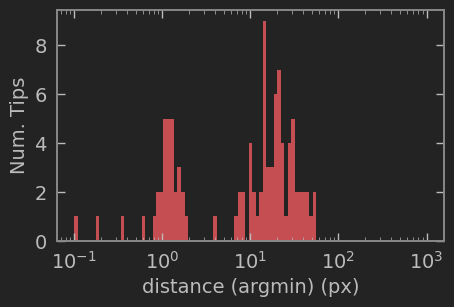

In [30]:
#DONE: visualize histogram of the minimum distance to all other particles during its lifetime
fontsize=14
bins=100
ycol='mindist'
# ycol='minti'
# ycol='mintf'
bins=np.logspace(-1,3,100)
fig,ax=plt.subplots(figsize=(5,3))
df_mindist[ycol].hist(bins=bins,color='r',ax=ax)
format_plot(ax=ax,xlabel='distance (argmin) (px)',ylabel='Num. Tips',fontsize=fontsize)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.grid(None)
plt.show()

In [31]:
# #GOAL: compute ^that for many neurons
# #DONE: wrap ^that to foo
# #DONE: compute it without printing on 1 core end to end
# df_mindist,dp = comp_mindist_dataframe(
#     width=200,
#     height=200,
#     mintime=100., #ms
#     tpad=10., #ms
#     min_lifetime = 100., #ms
#     printing=False)#,**kwargs)
# #TODO: dask.bag over ^that shizzle
# #heretim

In [32]:
task_lst=[]
for fn in os.listdir(folder):
    input_dir = os.path.join(folder,fn)
    task_lst.append(input_dir)
assert os.path.exists(input_dir)
print(f"{len(task_lst)=}")

len(task_lst)=159


In [33]:
def routine(task):
    input_dir=task
    try:
        df_mindist,dp = comp_mindist_dataframe(input_dir,
            width=200,height=200,
            mintime=100., #ms
            tpad=10., #ms
            min_lifetime = 100., #ms
            printing=False)#,**kwargs)
        return df_mindist,dp
    except ValueError as e:
        return f"Warning: {e}  for {input_dir}"

In [282]:
# #test the routine
# df_mindist,dp = comp_mindist_dataframe(input_dir,
#             width=200,height=200,
#             mintime=100., #ms
#             tpad=10., #ms
#             min_lifetime = 100., #ms
#             printing=False)#,**kwargs)

In [283]:
npartitions=os.cpu_count()-2
retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
beep(4)

run time for evaluating routine was 5679.48 seconds, yielding 159 values returned


0

In [284]:
#TODO: try parallelizing with multiprocessing
#Q: did i do this in pv_reentry or in neurophysics?

In [285]:
l1,l2=[],[]
for trial_num,rv in enumerate(retval):
    if type(rv)==str:
        print(rv)
    else:
        df_mindist,dp = rv
        df_mindist['trial_num']=trial_num
        dp['trial_num']=trial_num
        l1.append(df_mindist)
        l2.append(dp)
df_mindist=pd.concat(l1); del l1
dp=pd.concat(l2); del l2

In [286]:
df_mindist['r']=0.025*df_mindist['mindist']

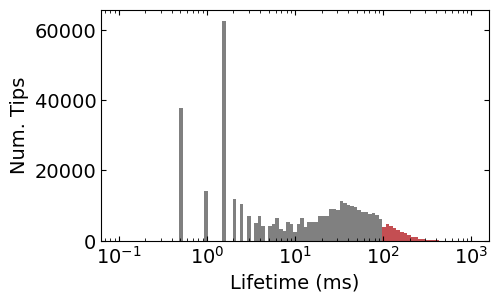

In [287]:
#DONE: make a histogram of lifetimes
fontsize=14
bins=100
bins=np.logspace(-1,3,100)
fig,ax=plt.subplots(figsize=(5,3))
dp[dp['isll']==0]['dur'].hist(bins=bins,color='gray',ax=ax)
dp[dp['isll']==1]['dur'].hist(bins=bins,color='r',ax=ax)
format_plot(ax=ax,xlabel='Lifetime (ms)',ylabel='Num. Tips',fontsize=fontsize)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(None)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

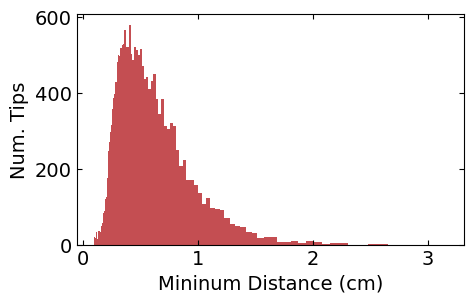

In [288]:
#DONE: visualize histogram of the minimum distance to all other particles during its lifetime
fontsize=14
bins=100
ycol='r'
# ycol='mindist'
# ycol='minti'
# ycol='mintf'
bins=np.logspace(-1,0.5,100)
fig,ax=plt.subplots(figsize=(5,3))
df_mindist[ycol].hist(bins=bins,color='r',ax=ax)
format_plot(ax=ax,xlabel='Mininum Distance (cm)',ylabel='Num. Tips',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.grid(None)
plt.show()

In [289]:
print(f"{model_name=}")

model_name='Luo-Rudy'


In [290]:
#DONE: make a histogram averaged over many termination events
#HINT: consider groupby trial_num,particle1 or something
#TODO: visualize ^that as cdf
#TODO: visualize ^that as a survival function
#TODO: claim ^that is the hazard function of topological events

In [291]:
#DONE: save as .pkl
#DONE: rerun for LR
save_dir = folder.replace('trajectories','mindist_rxn_range.pkl')
print(f"{save_dir=}")

save_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/mindist_rxn_range.pkl'


In [292]:
#save!
pdict=dict(dp=dp,df_mindist=df_mindist)
save_to_pickle(save_dir, pdict)

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/mindist_rxn_range.pkl'

In [293]:
x=bins
values = df_mindist['r'].values
data = np.sort(values + abs(min(values)))
# cdf = cumtrapz(x=x, y=data ) 
cdf = cumtrapz(y=data) 
cdf = cdf / max(cdf)
cdf.shape

(29747,)

In [294]:
np.cumsum(data).shape,data.shape,bins.shape

((29748,), (29748,), (100,))

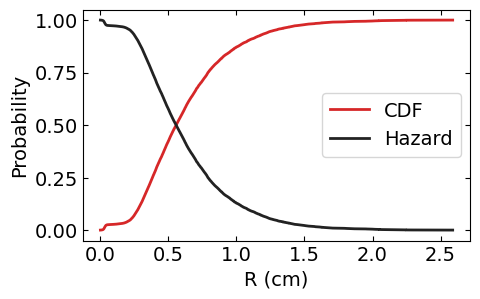

In [295]:
fig, ax = plt.subplots(ncols=1,figsize=(5,3))
# ax1 = ax.twinx()
ax.plot(data[1:],cdf,label='CDF',color='C3',lw=2)
ax.plot(data[1:],1-cdf,label='Hazard',color='k',lw=2)
format_plot(ax=ax,xlabel='R (cm)',ylabel='Probability',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(loc='center right',fontsize=fontsize)
# ax.legend(loc='lower center',fontsize=fontsize)
plt.show()

In [296]:
x=data[1:]
y=1-cdf
#fit a sigmoid to it!

In [297]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, x, y, p0, method='dogbox')
popt.shape, pcov.shape

((4,), (4, 4))

In [302]:
f"L ,x0, k, b: {popt}"

'L ,x0, k, b: [ 0.95428583  0.52430684 -6.37987385  0.08111723]'

In [298]:
L,x0,k,b = popt

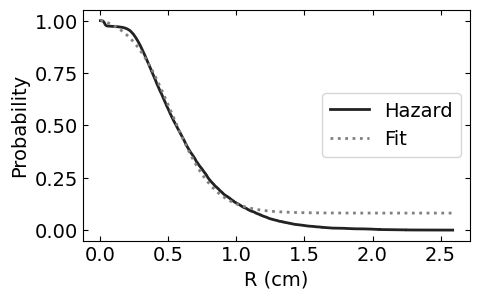

In [299]:
fig, ax = plt.subplots(ncols=1,figsize=(5,3))
ax.plot(x,y,label='Hazard',color='k',lw=2)
ax.plot(x,sigmoid(x, L ,x0, k, b),':',label='Fit',color='gray',lw=2)

format_plot(ax=ax,xlabel='R (cm)',ylabel='Probability',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(loc='center right',fontsize=fontsize)
# ax.legend(loc='lower center',fontsize=fontsize)
plt.show()

In [301]:
print(f"{np.median(x)=}")

np.median(x)=0.30812080969367484


In [300]:
def sigmoid_simple(x ,x0, k):
    L=1;b=0
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [np.median(x),1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid_simple, x, y, p0, method='dogbox')
popt.shape, pcov.shape

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
x0,k = popt
print(f"{x0=} cm, {1/k=} cm")

In [ ]:
fig, ax = plt.subplots(ncols=1,figsize=(5,3))
ax.plot(x,y,label='Hazard',color='C1',lw=2)
ax.plot(x,sigmoid_simple(x, x0, k),':',label='Fit',color='k',lw=2)

format_plot(ax=ax,xlabel='R (cm)',ylabel='Probability',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(loc='center right',fontsize=fontsize)
# ax.legend(loc='lower center',fontsize=fontsize)
plt.show()

In [ ]:
# curve_fit?

In [ ]:
beep(3)

$$
P_{rxn}(R) = \Big(1+e^{(r-R)/\lambda}\Big)^{-1}
$$

# TODO: compute histogram from saved pickle

In [48]:
#FK
save_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/mindist_rxn_range.pkl'
# #LR
# save_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/mindist_rxn_range.pkl'
data=load_pickle(save_dir)
data.keys()

dict_keys(['dp', 'df_mindist'])

In [49]:
df_mindist = data['df_mindist']
dp = data['dp']

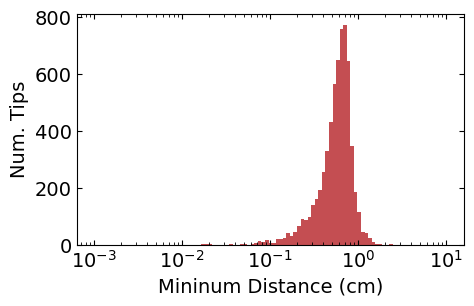

In [50]:
#DONE: visualize histogram of the minimum distance to all other particles during its lifetime
fontsize=14
bins=100
ycol='r'
# ycol='mindist'
# ycol='minti'
# ycol='mintf'
bins=np.logspace(-3,1,100)
fig,ax=plt.subplots(figsize=(5,3))
df_mindist[ycol].hist(bins=bins,color='r',ax=ax)
format_plot(ax=ax,xlabel='Mininum Distance (cm)',ylabel='Num. Tips',fontsize=fontsize)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.grid(None)
plt.show()
#heretim

# scratchwerk

In [67]:
# #compute the minimum distance to all other particles during its lifetime
# d = df[(df['t']>=row['min'])&(df['t']<=row['max'])]
# for particle2 in sorted(np.unique(d['particle'].values)):
#     pass

In [68]:
#TODO: compute the minimum distance to this other particle

In [ ]:
#TODO: identify nearest particle at birth
#TODO: identify nearest particle at death
#TODO: identify nearest remaining particle
#TODO: record

In [118]:
# #TODO: recall annihilation mates
# input_dir.replace('trajectories','annihilations')

In [ ]:
#TODO: remove any unreasonable annihlation mates

#TODO: for each remaining annihilation,

#TODO: compute the nearest apparent distance

#TODO: compute the nearest apparent distance of any other spiral tip 
#    that exists during the trajectory of either spiral tip in the pair

#TODO: record

In [119]:
# # num_termination_events = df['trial_num'].max()
# minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# printing=True
# if printing:
#     print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) ")

In [120]:
# # navg = 7
# # navg = 5
# # navg = 10 #4ms
# # navg = 25 #10ms
# navg = 15 #6ms
# navg = 13 #pretty good
# print(f"savgol smoothing window: {dt*navg} ms")
# kwargs_savgol=dict(window_length=navg,
#             polyorder=3,deriv=1,
#             delta=1.0,axis=-1,mode='interp')